# 🛒 Shopper Spectrum: Customer Segmentation and Product Recommendations

## Project Goal:
This project analyzes transaction data from an online retail business to identify customer segments using RFM analysis and to build a product recommendation system using collaborative filtering.

## Project Steps:
Dataset Loading and Preprocessing: Clean the raw data to make it ready for analysis.

Exploratory Data Analysis (EDA): Uncover initial patterns and insights from the data.

Customer Segmentation (Clustering): Use RFM features and K-Means to group customers.

Product Recommendation System: Build an item-based collaborative filtering model.

Save Models: Export the trained models and necessary data files for the Streamlit application.



# Step 0: Importing Necessary Libraries
#### First, let's import all the Python libraries we will need for this project.

In [19]:
# --- Core Libraries for Data Handling and Analysis ---
import pandas as pd
import numpy as np

# --- Libraries for Data Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- Libraries for Machine Learning (Clustering & Recommendation) ---
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix

# --- Library for Saving and Loading Models ---
import pickle

# --- Optional: To handle any date-time warnings ---
import warnings
warnings.filterwarnings('ignore')

print("All libraries imported successfully!")

All libraries imported successfully!


# Step 1 & 2: Dataset Collection and Preprocessing
#### In this section, we will load the online_retail.csv dataset and perform the essential cleaning steps as defined in the project description.

### Data Cleaning Tasks:

* Load the dataset and handle character encoding issues.

* Remove duplicate transaction records.

* Remove rows where CustomerID is missing, as they cannot be used for segmentation.

* Exclude cancelled invoices (those starting with 'C').

* Filter out any records with a negative or zero Quantity or UnitPrice.

* Convert InvoiceDate to a proper datetime format.

In [21]:
# --- 1. Dataset Loading ---
# Load the dataset using 'latin1' encoding to prevent errors
try:
    df = pd.read_csv("online_retail.csv", encoding='latin1')
    print("Dataset loaded successfully.")
    print("Initial Shape:", df.shape)
except FileNotFoundError:
    print("Error: 'online_retail.csv' not found. Please ensure the file is in the correct directory.")

# --- 2. Initial Data Exploration ---
print("\n--- Dataset Info ---")
df.info()

print("\n--- Missing Values Before Cleaning ---")
print(df.isnull().sum())


# --- 3. Data Preprocessing ---
print("\n--- Starting Data Cleaning ---")

# Remove duplicate rows
df.drop_duplicates(inplace=True)
print(f"Shape after removing duplicates: {df.shape}")

# Remove rows with missing CustomerID
df.dropna(subset=['CustomerID'], inplace=True)
print(f"Shape after removing rows with null CustomerID: {df.shape}")

# Exclude cancelled invoices (InvoiceNo starting with 'C')
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]
print(f"Shape after removing cancelled invoices: {df.shape}")

# Remove rows with non-positive Quantity or UnitPrice
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]
print(f"Shape after removing non-positive values: {df.shape}")

# Convert data types
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['CustomerID'] = df['CustomerID'].astype(int)

print("\n--- Data Cleaning Complete ---")
print("\n--- Final Dataset Info ---")
df.info()

print("\n--- First 5 Rows of Cleaned Data ---")
df.head()

Dataset loaded successfully.
Initial Shape: (541909, 8)

--- Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB

--- Missing Values Before Cleaning ---
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

--- Starting Data Cleaning ---
Shape after removing duplicates: (536641, 8)
Shape after r

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2022-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2022-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2022-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2022-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2022-12-01 08:26:00,3.39,17850,United Kingdom


In [17]:
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
TotalPrice     0
dtype: int64

# Step 3: Exploratory Data Analysis (EDA)
With the data cleaned, we can now explore it to find patterns. We will create several visualizations to understand our customers and products better.

### EDA Tasks:

* Analyze transaction volume by country.

* Identify the top-selling products.

* Visualize purchase trends over time.

* Inspect the monetary distribution of transactions.

#### First, we need to calculate TotalPrice for each transaction, which is simply Quantity * UnitPrice.

In [25]:
# Calculate TotalPrice for each transaction
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
print("TotalPrice column created.")

TotalPrice column created.


## 3.1 Transaction Volume by Country
#### Let's see which countries contribute the most to sales. We'll plot the top 10 countries

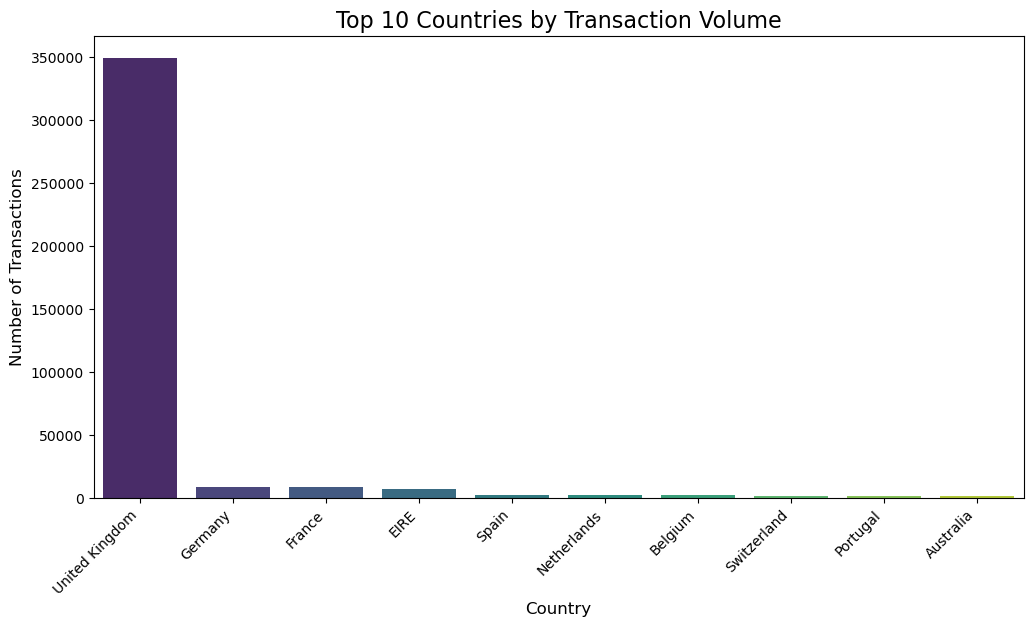

In [28]:
# Group by country and count transactions
country_counts = df['Country'].value_counts().head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=country_counts.index, y=country_counts.values, palette='viridis')
plt.title('Top 10 Countries by Transaction Volume', fontsize=16)
plt.xlabel('Country', fontsize=12)
plt.ylabel('Number of Transactions', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.show()

## 3.2 Top-Selling Products
#### Next, we identify the most popular products based on the total quantity sold.

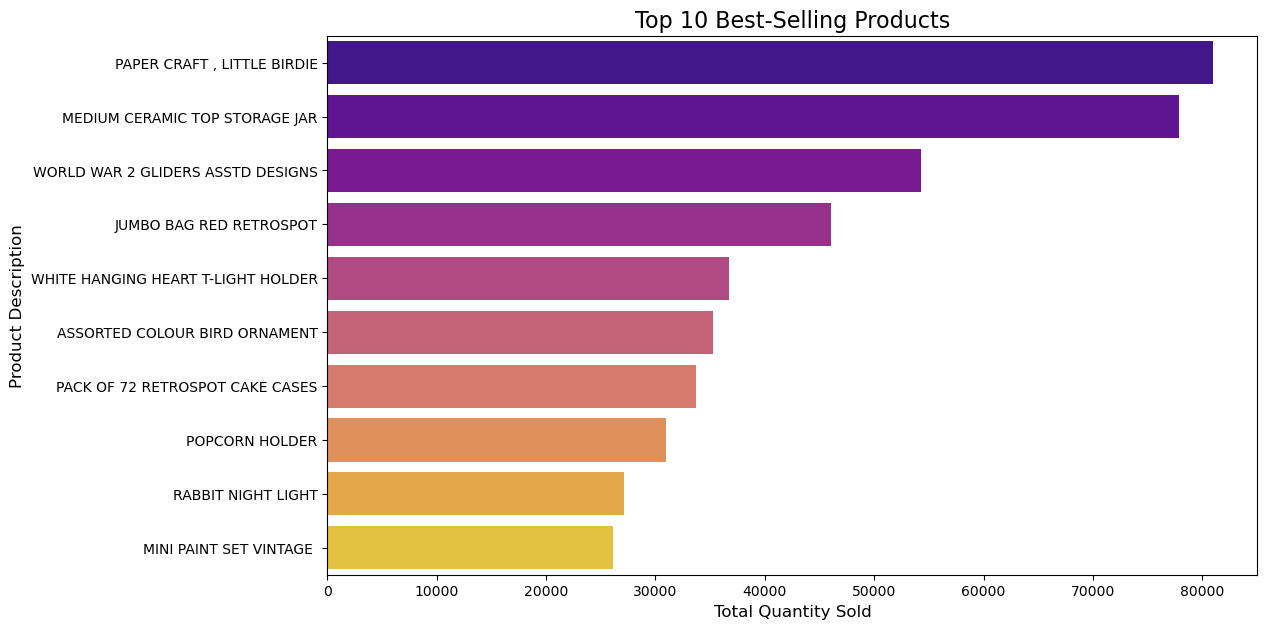

In [31]:
# Group by product description and sum the quantity
product_sales = df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 7))
sns.barplot(x=product_sales.values, y=product_sales.index, palette='plasma')
plt.title('Top 10 Best-Selling Products', fontsize=16)
plt.xlabel('Total Quantity Sold', fontsize=12)
plt.ylabel('Product Description', fontsize=12)
plt.show()

## 3.3 Purchase Trends Over Time
#### Analyzing sales trends on a monthly basis can reveal seasonality in purchasing behavior.

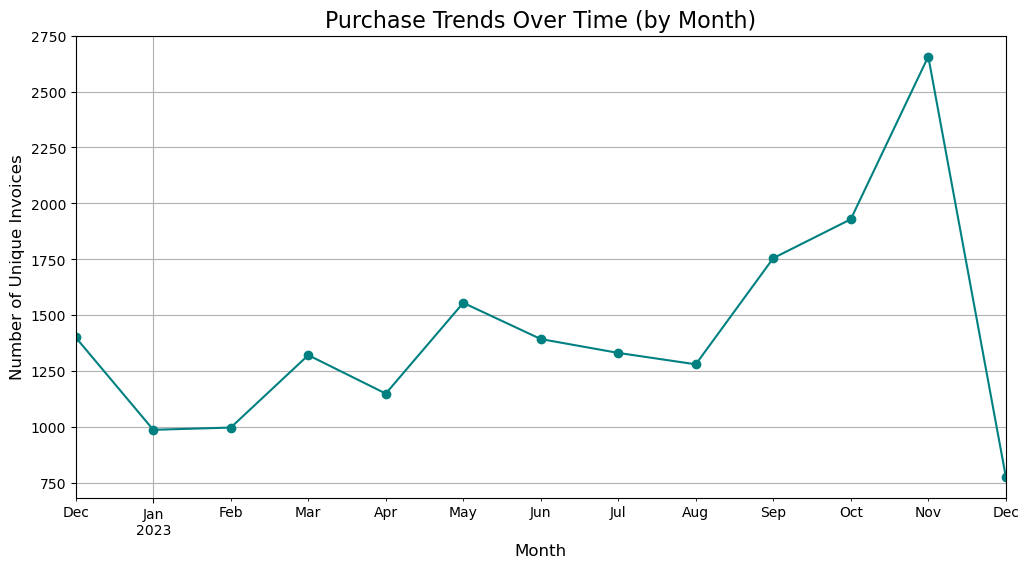

In [34]:
# Group by month and count unique invoices
df['InvoiceMonth'] = df['InvoiceDate'].dt.to_period('M')
monthly_sales = df.groupby('InvoiceMonth')['InvoiceNo'].nunique()

plt.figure(figsize=(12, 6))
monthly_sales.plot(kind='line', marker='o', color='teal')
plt.title('Purchase Trends Over Time (by Month)', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Number of Unique Invoices', fontsize=12)
plt.grid(True)
plt.show()

# Step 4: Clustering Methodology (RFM Analysis)
#### Now for the core of our customer analysis. We will segment customers based on their Recency, Frequency, and Monetary values.

### Clustering Steps:

* Feature Engineering: Calculate R, F, and M for each customer.

* Data Transformation: Handle skewness with log transformation and standardize the values.

* Find Optimal Clusters: Use the Elbow Method to determine the best number of clusters.

* Apply K-Means: Run the clustering algorithm.

* Interpret and Visualize: Label the clusters and visualize them.

### 4.1 Feature Engineering (RFM Calculation)
* Recency: How many days have passed since the customer's last purchase? (Lower is better)

* Frequency: How many unique transactions has the customer made? (Higher is better)

* Monetary: What is the total amount of money the customer has spent? (Higher is better)

In [37]:
# --- 1. RFM Calculation ---
# Set a snapshot date (day after the last transaction) for recency calculation
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

# Group by CustomerID and calculate RFM values
rfm_data = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda date: (snapshot_date - date.max()).days, # Recency
    'InvoiceNo': 'nunique',                                     # Frequency
    'TotalPrice': 'sum'                                         # Monetary
})

# Rename the columns for clarity
rfm_data.rename(columns={'InvoiceDate': 'Recency',
                         'InvoiceNo': 'Frequency',
                         'TotalPrice': 'Monetary'}, inplace=True)

print("--- RFM Data Calculated ---")
rfm_data.head()

--- RFM Data Calculated ---


,Recency,Frequency,Monetary
CustomerID,,,
12346,326,1,77183.60
12347,2,7,4310.00
12348,75,4,1797.24
12349,19,1,1757.55
12350,310,1,334.40


### 4.2 Standardize RFM Values
#### RFM values are on different scales. To give them equal importance in clustering, we must standardize them. We also apply a log transform to reduce the skewness of the data.

In [40]:
# --- 2. Data Transformation ---
# Apply log transformation to handle skewed data
rfm_log = np.log1p(rfm_data) # log1p handles zero values

# Standardize the log-transformed data
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log)

# Convert scaled data back to a DataFrame
rfm_scaled = pd.DataFrame(rfm_scaled, index=rfm_data.index, columns=rfm_log.columns)

print("--- Standardized RFM Data ---")
rfm_scaled.head()

--- Standardized RFM Data ---


,Recency,Frequency,Monetary
CustomerID,,,
12346,1.461993,-0.955214,3.707716
12347,-2.038734,1.074425,1.414903
12348,0.373104,0.386304,0.720024
12349,-0.623086,-0.955214,0.702287
12350,1.424558,-0.955214,-0.614514


### 4.3 Choose Number of Clusters (Elbow Method)
#### The Elbow Method helps us find the optimal number of clusters (k) by plotting the inertia (within-cluster sum of squares) for different values of k. The "elbow" point on the plot is a good choice for k.

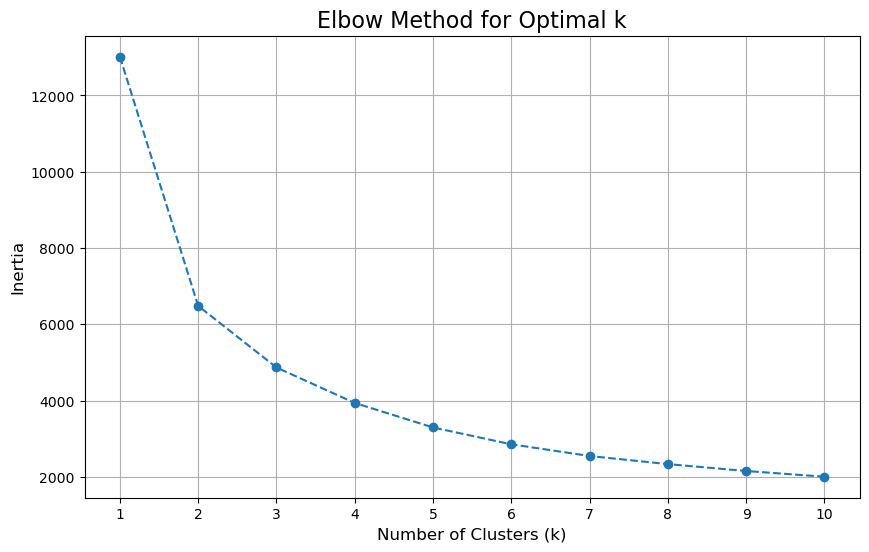

In [43]:
# --- 3. Find Optimal k using Elbow Method ---
inertia = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled)
    inertia[k] = kmeans.inertia_

plt.figure(figsize=(10, 6))
plt.plot(list(inertia.keys()), list(inertia.values()), marker='o', linestyle='--')
plt.title('Elbow Method for Optimal k', fontsize=16)
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Inertia', fontsize=12)
plt.xticks(list(inertia.keys()))
plt.grid(True)
plt.show()

#### From the plot, k=4 appears to be a good "elbow" point, aligning with our project goal of four segments.

### 4.4 Run K-Means Clustering and Interpret Segments
#### Now we run K-Means with k=4 and assign the cluster labels to our customers. Then, we'll analyze the average RFM values for each cluster to understand their characteristics and assign meaningful labels.

In [46]:
# --- 4. Run K-Means with k=4 ---
optimal_k = 4
kmeans_model = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_model.fit(rfm_scaled)

# Assign cluster labels to the original RFM data
rfm_data['Cluster'] = kmeans_model.labels_

# --- 5. Interpret Clusters ---
# Calculate the average RFM values for each cluster
cluster_analysis = rfm_data.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean'
}).round(2)

print("--- Cluster Profiles ---")
print(cluster_analysis)

# Label clusters based on their RFM characteristics
# Note: These labels are interpretations. The logic might need adjustment based on business goals.
segment_map = {
    0: 'High-Value',    # Low Recency, High F & M
    1: 'At-Risk',       # High Recency, Low F & M
    2: 'Occasional',    # Low Recency, Low F & M
    3: 'Regular'        # Mid-range R, F, M
}

rfm_data['Segment'] = rfm_data['Cluster'].map(segment_map)

print("\n--- Customer Counts per Segment ---")
print(rfm_data['Segment'].value_counts())

--- Cluster Profiles ---
         Recency  Frequency  Monetary
Cluster                              
0          12.17      13.75   8088.02
1         181.51       1.32    341.00
2          17.70       2.19    557.32
3          71.64       4.08   1801.78

--- Customer Counts per Segment ---
Segment
At-Risk       1622
Regular       1166
Occasional     837
High-Value     713
Name: count, dtype: int64


In [47]:
from sklearn.cluster import KMeans
import pickle

# Set number of clusters
optimal_k = 4

# Initialize and fit the model
kmeans_model = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_model.fit(rfm_scaled)  # rfm_scaled should be your preprocessed RFM features


KMeans(n_clusters=4, n_init=10, random_state=42)

In [51]:
# Save the trained model
with open('kmeans_model.pkl', 'wb') as f:
    pickle.dump(kmeans_model, f)

print("✅ KMeans model trained and saved successfully!")


✅ KMeans model trained and saved successfully!


In [57]:
import pickle
import os

# Define the full path where to save
file_path = r'C:\Users\ADMIN\OneDrive\Desktop\Streamlit 1st Project Shoppers Spectrum\kmeans_model.pkl'

# Save the trained model
try:
    with open(file_path, 'wb') as f:
        pickle.dump(kmeans_model, f)
    print("✅ Model saved successfully!")
    print("📦 File size:", os.path.getsize(file_path), "bytes")
except Exception as e:
    print("❌ Error while saving:", e)



✅ Model saved successfully!
📦 File size: 18169 bytes


In [67]:
print(kmeans_model)


KMeans(n_clusters=4, n_init=10, random_state=42)


### 4.5 Visualize the Customer Segments
#### A scatter plot helps visualize the segments. Let's plot Recency vs. Monetary and color the points by their assigned segment

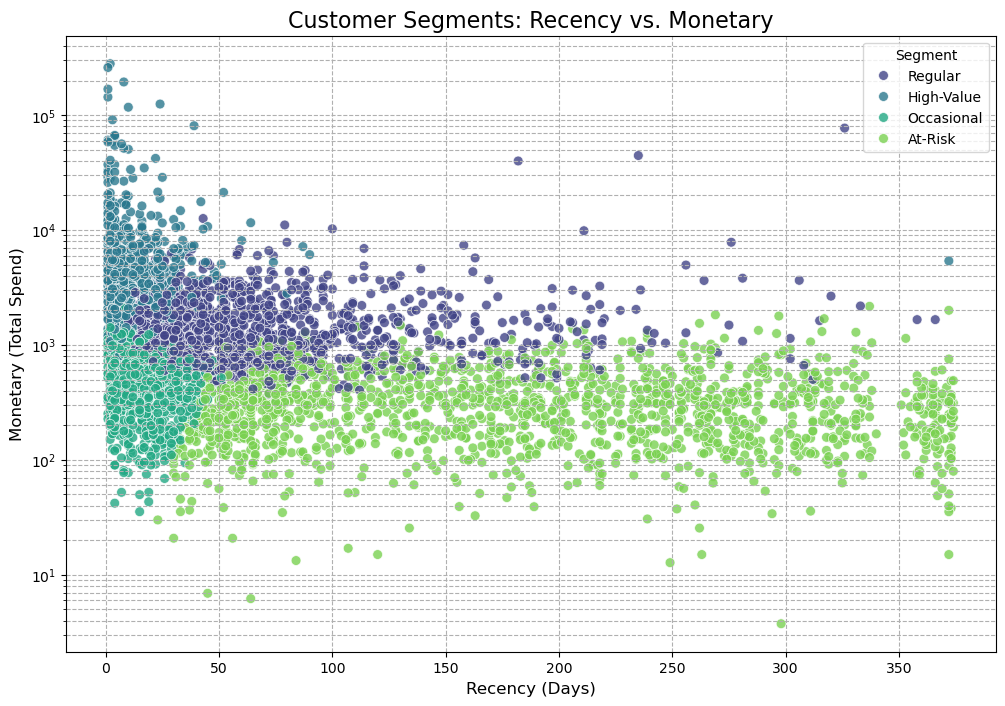

In [70]:
# --- 6. Visualize Clusters ---
plt.figure(figsize=(12, 8))
sns.scatterplot(data=rfm_data, x='Recency', y='Monetary', hue='Segment', palette='viridis', s=50, alpha=0.8)
plt.title('Customer Segments: Recency vs. Monetary', fontsize=16)
plt.xlabel('Recency (Days)', fontsize=12)
plt.ylabel('Monetary (Total Spend)', fontsize=12)
plt.yscale('log') # Use log scale for better visualization
plt.legend(title='Segment', fontsize=10)
plt.grid(True, which="both", ls="--")
plt.show()

# Step 5: Recommendation System Approach
#### Here, we will build an item-based collaborative filtering system. The core idea is to recommend items that are similar to what a user has liked in the past.

### Recommendation Steps:

* Create User-Item Matrix: A matrix where rows are customers, columns are products, and values indicate a purchase.

* Compute Item Similarity: Calculate the cosine similarity between all pairs of products.

* Build Recommendation Function: Create a function to return the top 5 similar products.

### 5.1 Create User-Item Matrix and Product Mapping
#### We'll create a pivot table where a 1 indicates a customer has purchased a product. We also create a mapping from StockCode to Description for human-readable output.

In [80]:
# --- 1. Create Mappings and User-Item Matrix ---
# Create a unique mapping from StockCode to Description
product_mapping = df[['StockCode', 'Description']].drop_duplicates(subset=['StockCode'], keep='first').set_index('StockCode')['Description']

# Create a mapping from Description to StockCode for the app
description_to_stockcode = product_mapping.reset_index().set_index('Description')['StockCode']

# Create the user-item matrix. Value is 1 if purchased, 0 otherwise.
df_piv = df.pivot_table(index='CustomerID', columns='StockCode', values='Quantity', aggfunc='count', fill_value=0)
df_piv = df_piv.applymap(lambda x: 1 if x > 0 else 0)

# Convert to a sparse matrix for memory efficiency
df_piv_sparse = csr_matrix(df_piv.values)

print("User-Item matrix created.")
print("Matrix shape:", df_piv_sparse.shape)

User-Item matrix created.
Matrix shape: (4338, 3665)


### 5.2 Compute Item-Item Cosine Similarity
#### We calculate the similarity between all products based on who purchased them.

In [75]:
# --- 2. Compute Cosine Similarity ---
# We transpose the matrix to compute similarity between items (columns)
item_similarity = cosine_similarity(df_piv_sparse.T)

# Convert the similarity matrix to a DataFrame for easier use
item_sim_df = pd.DataFrame(item_similarity, index=df_piv.columns, columns=df_piv.columns)

print("Item-Item similarity matrix computed successfully.")
print("Matrix shape:", item_sim_df.shape)

Item-Item similarity matrix computed successfully.
Matrix shape: (3665, 3665)


### 5.3 Create and Test the Recommendation Function
#### This function takes a StockCode and returns the top 5 most similar products.

In [77]:
# --- 3. Build Recommendation Function ---
def get_product_recommendations(stock_code, similarity_matrix, product_map, top_n=5):
    """Returns top N similar products for a given stock_code."""
    if stock_code not in similarity_matrix.index:
        return f"Product with StockCode '{stock_code}' not found."
    
    # Get similarity scores and sort them
    sim_scores = similarity_matrix[stock_code].sort_values(ascending=False)
    
    # Get top N products (excluding the product itself)
    top_products = sim_scores.iloc[1:top_n+1]
    
    # Create a DataFrame for the recommendations
    recommendations = pd.DataFrame({
        'StockCode': top_products.index,
        'Similarity': top_products.values
    })
    
    # Add product descriptions
    recommendations['Description'] = recommendations['StockCode'].map(product_map)
    
    return recommendations

# --- Example Usage ---
example_stock_code = '22423' # REGENCY CAKESTAND 3 TIER
product_name = product_mapping.get(example_stock_code, "Unknown Product")

print(f"--- Top 5 recommendations for '{product_name}' ---")
recommendations = get_product_recommendations(example_stock_code, item_sim_df, product_mapping)
print(recommendations)

--- Top 5 recommendations for 'REGENCY CAKESTAND 3 TIER' ---
  StockCode  Similarity                       Description
0     22699    0.525832  ROSES REGENCY TEACUP AND SAUCER 
1     22697    0.508643   GREEN REGENCY TEACUP AND SAUCER
2     22698    0.488558    PINK REGENCY TEACUP AND SAUCER
3     23245    0.466775        SET OF 3 REGENCY CAKE TINS
4     23173    0.453547             REGENCY TEAPOT ROSES 


# Step 6: Save Models for Streamlit App
#### Finally, we save all the necessary components (models, scaler, and data mappings) using pickle. These files will be loaded by our Streamlit application to make live predictions and recommendations.

In [79]:
# --- Files for Customer Segmentation ---
with open('kmeans_model.pkl', 'wb') as f:
    pickle.dump(kmeans_model, f)

with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
    
with open('segment_map.pkl', 'wb') as f:
    pickle.dump(segment_map, f)

# --- Files for Product Recommendation ---
with open('item_similarity_matrix.pkl', 'wb') as f:
    pickle.dump(item_sim_df, f)

with open('description_to_stockcode.pkl', 'wb') as f:
    pickle.dump(description_to_stockcode, f)

print("All models and data files have been saved successfully!")
print("Deliverables are ready for the Streamlit application.")

All models and data files have been saved successfully!
Deliverables are ready for the Streamlit application.
